# Calculate molecular descriptors by graph neural net

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from rdkit import Chem
import numpy as np

In [2]:
#load database
path="../database/small_db.csv"
df=pd.read_csv(path)
df

,Unnamed: 0,boiling temperature,melting temperature,density,viscosity,SMILES
0,0,-0.999826,-1.072944,-1.466345,-0.857140,CCCCCC
1,1,-0.407466,-0.997391,-1.355887,-0.708313,CCCCCCC
2,2,0.113976,-0.218786,-1.268441,-0.613162,CCCCCCCC
3,3,-0.769429,0.961131,-0.918658,-0.293072,C1CCCCC1
4,4,-0.769429,0.944862,-0.458417,-0.422331,c1ccccc1
...,...,...,...,...,...,...
157,157,0.230720,-1.437014,0.098475,-0.366290,CCC[N+](=O)[O-]
158,158,-0.422740,2.176619,-0.914055,-0.745890,CCC#N
159,159,-0.029463,2.408080,-0.775983,-0.608380,CCCC#N
160,160,-0.292849,1.903800,-1.006104,-0.668010,CC(C)C#N


In [3]:
#set target y
target="boiling temperature"
#target="melting temperature"
#target="density"
#target="viscosity"

#prepare mol objects and y
smiles_list=df["SMILES"]
mol_list=[Chem.MolFromSmiles(s) for s in df["SMILES"]]
y_list=np.array(df[target],dtype=np.float32).reshape(-1,1)

#in this demo, train/test dataset is made
spl_ratio=0.8
train_mols,test_mols,train_y,test_y=train_test_split(mol_list,y_list,test_size=0.3)

#if you want to just calculate descriptors, train all data
#train_mols,train_y=mol_list,y_list

In [4]:
#prepare graph objects from mol objects
from gnn import mol2dgl_single,collate,ATOM_FDIM, MID_DIM,GCN
train_graphs = mol2dgl_single(train_mols)
test_graphs = mol2dgl_single(test_mols)

Using backend: pytorch
/home/kh/anaconda3/envs/self/lib/python3.6/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [5]:
#set dataloader
from torch.utils.data import DataLoader
BATCH_SIZE=16
dataset = list(zip(train_graphs, train_y))
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate)

In [6]:
#define regressor

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dgl


class Regressor(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_size):
        super(Regressor, self).__init__()
        self.layers = nn.ModuleList([GCN(in_dim, hidden_dim, F.relu),
                                    GCN(hidden_dim, hidden_dim, F.relu)])
        self.regress = nn.Linear(hidden_dim, out_size)
        self.intermediate_mode=0
        
    def forward(self, g):
        h = g.ndata['h']
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        
        if self.intermediate_mode==2:
            return hg
        elif self.intermediate_mode==1:
            return self.regress(hg)
        else:
            return self.regress(hg),hg


In [7]:
model = Regressor(ATOM_FDIM, MID_DIM, 1)

# if intermediate_mode == 1, return y. if 2, return hidden layer outputs (= neural descriptor)
model.intermediate_mode=1
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

Regressor(
  (layers): ModuleList(
    (0): GCN(
      (linear): Linear(in_features=28, out_features=32, bias=True)
    )
    (1): GCN(
      (linear): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (regress): Linear(in_features=32, out_features=1, bias=True)
)

In [8]:
epoch_losses = []
for epoch in range(200):
    epoch_loss = 0
    for i, (bg, label) in enumerate(data_loader):
        bg.set_e_initializer(dgl.init.zero_initializer)
        bg.set_n_initializer(dgl.init.zero_initializer)        
        pred = model(bg)
        loss = loss_func(pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (i + 1)
    if (epoch+1) % 20 == 0:
        print('Epoch {}, loss {:.4f}'.format(epoch+1, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 20, loss 0.7185
Epoch 40, loss 0.6291
Epoch 60, loss 0.6560
Epoch 80, loss 0.5590
Epoch 100, loss 0.5284
Epoch 120, loss 0.4693
Epoch 140, loss 0.4655
Epoch 160, loss 0.4255
Epoch 180, loss 0.4668
Epoch 200, loss 0.3760


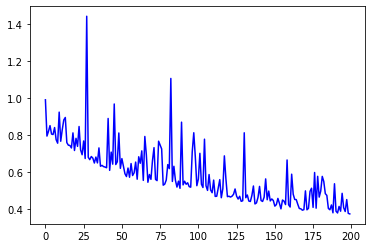

In [9]:
plt.plot(epoch_losses, c='b')

In [10]:
def batch_predict(model,graphs):

    model.eval()
    bg = dgl.batch(graphs)
    bg.set_e_initializer(dgl.init.zero_initializer)
    bg.set_n_initializer(dgl.init.zero_initializer)

    return model(bg).detach().numpy()

/home/kh/anaconda3/envs/self/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/kh/anaconda3/envs/self/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


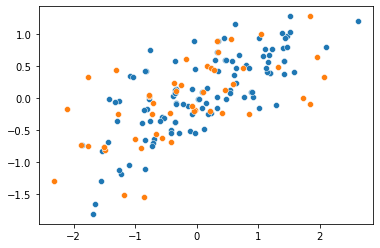

In [11]:
#predict

tr_pred_y=batch_predict(model,train_graphs)
te_pred_y=batch_predict(model,test_graphs)


sns.scatterplot(train_y.reshape(-1),tr_pred_y.reshape(-1))
sns.scatterplot(test_y.reshape(-1),te_pred_y.reshape(-1))

In [12]:
#output molecular descriptors

model.intermediate_mode=2
desc_array=batch_predict(model,train_graphs)
print(desc_array.shape)
desc_array

(113, 32)


array([[0.36878386, 0.20890903, 0.        , ..., 0.29236218, 0.35949525,
        0.3447403 ],
       [0.54445916, 0.4500169 , 0.        , ..., 0.4167077 , 0.21767834,
        0.25998813],
       [0.35692197, 0.27095714, 0.        , ..., 0.26822546, 0.25776905,
        0.38824657],
       ...,
       [0.77154046, 0.74897814, 0.        , ..., 0.58343506, 0.11439871,
        0.12355288],
       [0.3530692 , 0.183501  , 0.        , ..., 0.24780399, 0.16589752,
        0.5282407 ],
       [0.49353603, 0.3461177 , 0.        , ..., 0.34894222, 0.3011178 ,
        0.19189858]], dtype=float32)